# Auto insurance. Interview questions
- hello

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',85)
pd.set_option('display.max_columns',85)
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.describe()
df.info()
df.select_dtypes(include='object').columns # 3 columns are str


,vehicle_value,exposure,claim,claim_count,claim_cost,vehicle_age,owner_age
count,67062.000000,67856.000000,67856.000000,67856.000000,67856.000000,67185.000000,66289.000000
mean,17774.338657,0.468652,0.068144,0.072757,137.270167,2.674347,3.486355
std,12057.355897,0.290025,0.251995,0.278204,1056.297768,1.067584,1.425221
min,0.000000,0.002738,0.000000,0.000000,0.000000,1.000000,1.000000
25%,10100.000000,0.219028,0.000000,0.000000,0.000000,2.000000,2.000000
50%,15000.000000,0.446270,0.000000,0.000000,0.000000,3.000000,3.000000
75%,21500.000000,0.709103,0.000000,0.000000,0.000000,4.000000,5.000000
max,345600.000000,0.999316,1.000000,4.000000,55922.129883,4.000000,6.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vehicle_value  67062 non-null  float64
 1   exposure       67856 non-null  float64
 2   claim          67856 non-null  int64  
 3   claim_count    67856 non-null  int64  
 4   claim_cost     67856 non-null  float64
 5   vehicle_type   67856 non-null  object 
 6   vehicle_age    67185 non-null  float64
 7   owner_gender   67856 non-null  object 
 8   owner_area     67856 non-null  object 
 9   owner_age      66289 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 5.2+ MB


Index(['vehicle_type', 'owner_gender', 'owner_area'], dtype='object')

In [4]:
# checking missing value percentage
pct = df.isna().mean()
pct[pct>0]


vehicle_value    0.011701
vehicle_age      0.009889
owner_age        0.023093
dtype: float64

In [5]:
# Which area has the highest average claim cost for the top 3 vehicle type?
top_3 = df['vehicle_type'].value_counts()[:3].index # get the top 3 vehicle types

filt = df['vehicle_type'].isin(top_3) # get only the records of the top 3 vehicle types

df[filt].groupby('owner_area')['claim_cost'].mean().sort_values(ascending=False)[[0]]

owner_area
F    202.131412
Name: claim_cost, dtype: float64

In [6]:
# For each missing value, impute with median.
df = df.fillna(value=df.median())

/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_94807/4059612040.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(value=df.median())


In [7]:
# Clean vehicle_type to fix entry typos so that it contains only the following 7 unique values: HBACK , HDTOP , SEDAN , STNWG , TRUCK , UTE , OTHER .

# M1: slow
res = df['vehicle_type'].values
for i, s in enumerate(res):
    res[i] = ''.join(c.upper() for c in s if c.isalpha())

print(np.unique(res,return_counts=True))

# M2: change the unique type only
col = df['vehicle_type'].unique()
col
d = dict()

for s in col:
    d[s] = ''.join(c.upper() for c in s if c.isalpha())
d

print(df['vehicle_type'].map(d).value_counts())

# M3: regex
print(df.vehicle_type.str.replace('[^a-zA-Z]', '').str.upper().value_counts())

df['vehicle_type'] = df.vehicle_type.str.replace('[^a-zA-Z]', '').str.upper()



(array(['HBACK', 'HDTOP', 'OTHER', 'SEDAN', 'STNWG', 'TRUCK', 'UTE'],
      dtype=object), array([18915,  1579,  2532, 22233, 16261,  1750,  4586]))


array(['HBACK', 'UTE', 'STNWG', 'HDTOP', 'OTHER', 'SEDAN', 'TRUCK'],
      dtype=object)

{'HBACK': 'HBACK',
 'UTE': 'UTE',
 'STNWG': 'STNWG',
 'HDTOP': 'HDTOP',
 'OTHER': 'OTHER',
 'SEDAN': 'SEDAN',
 'TRUCK': 'TRUCK'}

SEDAN    22233
HBACK    18915
STNWG    16261
UTE       4586
OTHER     2532
TRUCK     1750
HDTOP     1579
Name: vehicle_type, dtype: int64
SEDAN    22233
HBACK    18915
STNWG    16261
UTE       4586
OTHER     2532
TRUCK     1750
HDTOP     1579
Name: vehicle_type, dtype: int64


/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_94807/4162052612.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  print(df.vehicle_type.str.replace('[^a-zA-Z]', '').str.upper().value_counts())
/var/folders/c2/yj8ksjmn34v5f9csr1s82d8r0000gn/T/ipykernel_94807/4162052612.py:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['vehicle_type'] = df.vehicle_type.str.replace('[^a-zA-Z]', '').str.upper()


In [11]:
# discretization
df['vehicle_value_cat'] = pd.cut(
    df.vehicle_value, 
    bins = [0, 2e4, 6e4, 1e5, np.inf], 
    labels=['LOW','MIDDLE','HIGH','VERY_HIGH'],
    right = False
)  
df

,vehicle_value,exposure,claim,claim_count,claim_cost,vehicle_type,vehicle_age,owner_gender,owner_area,owner_age,vehicle_value_cat
0,10600.0,0.303901,0,0,0.000000,HBACK,3.0,F,C,2.0,LOW
1,10300.0,0.648871,0,0,0.000000,HBACK,2.0,F,A,4.0,LOW
2,32600.0,0.569473,0,0,0.000000,UTE,2.0,F,E,2.0,MIDDLE
3,41400.0,0.317591,0,0,0.000000,STNWG,2.0,F,D,2.0,MIDDLE
4,7200.0,0.648871,0,0,0.000000,HBACK,4.0,F,C,2.0,LOW
...,...,...,...,...,...,...,...,...,...,...,...
67851,10700.0,0.654346,0,0,0.000000,SEDAN,2.0,M,A,6.0,LOW
67852,12300.0,0.908966,0,0,0.000000,SEDAN,4.0,M,C,3.0,LOW
67853,19300.0,0.312115,0,0,0.000000,STNWG,4.0,M,C,3.0,LOW
67854,9700.0,0.320329,1,1,7646.769989,HBACK,3.0,F,C,2.0,LOW


In [204]:
# Standardize each numerical variable with 0 mean and 1 standard deviation, except claim and claim_count and exposure

cols = df.select_dtypes(include = np.number).columns.drop(['claim', 'claim_count','exposure']) # or, include='number'
data = df[cols]

data = (data-data.mean())/data.std()

df[cols] = data

# df[cols].mean()
# df[cols].std()

# mean_ = df.mean(numeric_only=True).drop(index=['claim', 'claim_count','exposure'])
# sd_ = df.std(numeric_only=True).drop(index=['claim', 'claim_count','exposure'])
# index_ = df.std(numeric_only=True).drop(index=['claim', 'claim_count','exposure']).index

# (df[index_]-mean_)/sd_


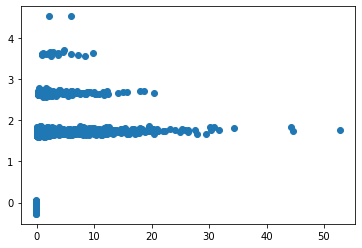

In [215]:
df = pd.get_dummies(df)
y = df['claim_cost']
X = df.drop(columns='claim_cost')
model = LinearRegression().fit(X,y)

plt.scatter(y, model.predict(X))

# y-model.predict(X)

